## Imports

In [1]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

## Read in Data

In [2]:
df1 = pd.read_csv("data/skin_care_cleaned.csv")
df1 = df1[["product_names", "product_category", "brand", "ingredient", "size", "price", "size_num", "size_unit", 
        'active_ingredient', 'inactive_ingredient', 'n_inactive_ingredient', 'n_active_ingredient']]

In [3]:
df1.active_ingredient = df1.active_ingredient.str.replace("(", "")
df1.active_ingredient = df1.active_ingredient.str.replace(")", "")
df1.active_ingredient = df1.active_ingredient.str.replace(",", "")
df1.active_ingredient = df1.active_ingredient.str.replace("%.", "%")
df1.active_ingredient = df1.active_ingredient.str.strip()
df1.active_ingredient = df1.active_ingredient.str.split("%")
df1 = df1.dropna(subset=["ingredient", "size", "size_unit"])

In [4]:
df2 = pd.read_csv("data/ingredients_skincare_dermstore.csv").drop(columns = ["Unnamed: 0", "url"])

In [5]:
# remove dollar signs from dataframe
df2["price"] = df2["price"].str.replace("$", "")

# turn active ingredients into list, input inactive ingredients
df2["active_ingredients"] = df2["active_ingredients"].str.split(",")
df2["inactive_ingredients"] = df2["inactive_ingredients"].fillna(df2["ingredients"])

# create and fill n_active_ingredient column
df2["n_active_ingredient"] = df2["active_ingredients"]
df2["n_active_ingredient"] = df2["n_active_ingredient"].fillna(0)
for index, row in df2.iterrows():
    if type(row["n_active_ingredient"]) == list:
        if len(row["n_active_ingredient"]) > 0:
            row["n_active_ingredient"] = len(row["n_active_ingredient"])
            
# create and fill n_inactive_ingredient column
df2["n_inactive_ingredient"] = df2["inactive_ingredients"].str.split(",")
for index, row in df2.iterrows():
    if type(row["n_inactive_ingredient"]) == list:
        if len(row["n_inactive_ingredient"]) > 0:
            row["n_inactive_ingredient"] = len(row["n_inactive_ingredient"])

In [6]:
# create product categories for items
df2["product_category"] = df2["product_name"]
for index, row in df2.iterrows():
    if "Serum" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Hydr" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Refi" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Bar" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Stem" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Neck" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "neck" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Peptide" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Resurfac" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Collagen" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Sun" in row["product_category"]:
        row["product_category"] = "Sunscreen" 
    elif "SPF" in row["product_category"]:
        row["product_category"] = "Sunscreen" 
    elif "Clean" in row["product_category"]:
        row["product_category"] = "Cleansers"
    elif "Wash" in row["product_category"]:
        row["product_category"] = "Cleansers"
    elif "Wipes" in row["product_category"]:
        row["product_category"] = "Cleansers"
    elif "Pads" in row["product_category"]:
        row["product_category"] = "Cleansers" 
    elif "Makeup Remover" in row["product_category"]:
        row["product_category"] = "Cleansers"
    elif "Soap" in row["product_category"]:
        row["product_category"] = "Cleansers" 
    elif "Cream" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Creme" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Night" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "night" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Nuit" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Gel" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Sleep" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Lotion" in row["product_category"]:
        row["product_category"] = "Daytime Moisturizer"
    elif "Moisturizer" in row["product_category"]:
        row["product_category"] = "Daytime Moisturizer"
    elif "Butter" in row["product_category"]:
        row["product_category"] = "Daytime Moisturizer"
    elif "Lip" in row["product_category"]:
        row["product_category"] = "Lip Scrub"
    elif "Mask" in row["product_category"]:
        row["product_category"] = "Face Mask"
    elif "Masque" in row["product_category"]:
        row["product_category"] = "Face Mask"
    elif "Acne" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Blemish" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Pore" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Spot" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Clinical" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "System" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Treatment" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Eye" in row["product_category"]:
        row["product_category"] = "Eye Cream & Treatment" 
    elif "Toner" in row["product_category"]:
        row["product_category"] = "Toner & Face Mist"
    elif "Mist" in row["product_category"]:
        row["product_category"] = "Toner & Face Mist"
    elif "mist" in row["product_category"]:
        row["product_category"] = "Toner & Face Mist" 
    elif "Scrub" in row["product_category"]:
        row["product_category"] = "Exfoliants"
    elif "Exfoli" in row["product_category"]:
        row["product_category"] = "Exfoliants" 
    elif "Polish" in row["product_category"]:
        row["product_category"] = "Exfoliants"
    elif "Glow" in row["product_category"]:
        row["product_category"] = "Exfoliants"
    elif "Peel" in row["product_category"]:
        row["product_category"] = "Exfoliants"
    elif "Vitamin C" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "Vita C" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "Refin" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "Bright" in row["product_category"]:
        row["product_category"] = "Skin Lightener"
    elif "-C" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "Vit C" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "- C" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "Oil" in row["product_category"]:
        row["product_category"] = "Facial Oil" 
    elif "Retinol" in row["product_category"]:
        row["product_category"] = "Retinol" 
    elif "Matt" in row["product_category"]:
        row["product_category"] = "Oil Control Products" 
        
product_types = ["Nighttime Moisturizer", "Cleansers", "Serum", "Exfoliants", "Eye Cream & Treatment", "Daytime Moisturizer",
                "Sunscreen", "Toner & Face Mist", "Face Mask", "Acne & Blemish Treatment", "Lip Balm", "Retinol",
                "Skin Lightener", "Oil Control Products", "Face Oil", "Vitamin C", "Lip Scrub"]
df2 = df2.loc[df2["product_category"].isin(product_types)]

In [7]:
# make and fill size_num column
pattern = r'(\d+(\.\d+)?)\s*(fl\.?\s*oz\.?|g\.?|ml\.?)'
extracted_values = df2["product_name"].str.extract(pattern, expand=True).fillna("")
df2["size_num"] = extracted_values.iloc[:, 0]


# make and fill size_unit column
df2["size_unit"] = df2["product_name"]
for index, row in df2.iterrows():
    if "g." in row["size_unit"]:
        row["size_unit"] = "grams"
    elif "fl. oz" in row["size_unit"]:
        row["size_unit"] = "fluid ounces"
    elif "ml" in row["size_unit"]:
        row["size_unit"] = "milliliters"
    else:
        row["size_unit"] = "piece/other"

# make and fill a size column
df2["size"] = df2["size_num"] + " " + df2["size_unit"]
df2["size"] = df2["size"].str.replace("grams", "g.")
df2["size"] = df2["size"].str.replace("milliliters", "ml")
df2["size"] = df2["size"].str.replace("fluid ounces", "fl. oz.")

In [8]:
df2 = df2[["product_name", "product_category", "brand", "ingredients", "size", "price", "size_num", "size_unit", 
          "active_ingredients", "inactive_ingredients", "n_inactive_ingredient", "n_active_ingredient"]]
df2.columns = ['product_names', 'product_category', 'brand', 'ingredient', 'size', 'price', 'size_num', 'size_unit', 
               'active_ingredient', 'inactive_ingredient', 'n_inactive_ingredient', 'n_active_ingredient']

In [9]:
df2["active_ingredient"] = df2["active_ingredient"].astype(str)
df2["active_ingredient"] = df2["active_ingredient"].str.replace("'", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("[", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("]", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("<strong>Active: </strong>", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("<strong>Active Ingredients:</strong>", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("Active Ingredients: ", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("\n", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("%", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace(")", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("(", "")

In [10]:
df = pd.concat([df1, df2]).reset_index().drop(columns = "index")
df

,product_names,product_category,brand,ingredient,size,price,size_num,size_unit,active_ingredient,inactive_ingredient,n_inactive_ingredient,n_active_ingredient
0,Clear Complexion Spot Treatment,Acne & Blemish Treatment,Merle Norman,"Active: Salicylic Acid (2%), Other: Alcohol D...",0.50 fl. oz.,20.0,15.0,ml,"[Salicylic Acid 2, ]","Alcohol Denat., Hamamelis Virginiana (Witch ...",10,1
1,Acne Solutions Emergency Gel Lotion,Acne & Blemish Treatment,Clinique,"Active: Benzoyl Peroxide (5%), Other: Water P...",0.50 fl. oz.,17.0,15.0,ml,"[Benzoyl Peroxide 5, ]","Water Purified, C12-15 Alkyl Benzoate, Glyc...",23,1
2,RESIST Daily Pore-Refining Solution 2% BHA,Acne & Blemish Treatment,Paula's Choice Skincare,"Water (Aqua), Dipropylene Glycol, Salicylic ...",3.00 fl. oz.,33.0,89.0,ml,NaN,"Water (Aqua), Dipropylene Glycol, Salicylic ...",26,0
3,Naturals Acne Spot Treatment,Acne & Blemish Treatment,Neutrogena,Active Ingredient: Salicylic Acid 1%. Inactive...,0.75 fl. oz.,8.49,22.0,ml,"[Salicylic Acid 1, ]","Water, Hydrated Silica, Glycerin, Dicapryl...",18,1
4,Normaderm Daily Anti-Acne Hydrating Lotion,Acne & Blemish Treatment,Vichy,"Active: Salicylic Acid 1%. Inactive: Water, G...",1.70 fl. oz.,23.5,50.0,ml,"[Salicylic Acid 1, ]","Water, Glycerin, Alcohol Denat., Phenyl Tr...",24,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7443,VERSO Verso Lip Serum (15 ml.),Serum,VERSO,"Theobroma Cacao Seed Butter, Bis-Diglyceryl Po...",15 ml,65.00,15,milliliters,nan,"Theobroma Cacao Seed Butter, Bis-Diglyceryl Po...",34,0
7444,Avene Cleanance HYDRA Soothing Cream (1.3 fl. ...,Cleansers,Avene,"Avene Thermal Spring Water, Carthamus Tinctori...",1.3 fl. oz.,25.00,1.3,fluid ounces,nan,"Avene Thermal Spring Water, Carthamus Tinctori...",25,0
7445,GlyDerm Gly Mist (8 fl. oz.),Toner & Face Mist,GlyDerm,"Purified Water, Propylene Glycol (and) Diazoli...",8 fl. oz.,23.00,8,fluid ounces,nan,"Purified Water, Propylene Glycol (and) Diazoli...",5,0
7446,Dr. Hauschka Revitalizing Mask (1 oz.),Face Mask,Dr. Hauschka,"Water/Aqua, Pyrus Cydonia (Quince) Seed Extrac...",piece/other,35.00,,piece/other,nan,"Water/Aqua, Pyrus Cydonia (Quince) Seed Extrac...",26,0


We'll be dropping size columns from our dataset as size of product is often determined by the type of product (i.e. lotions and sunscreens come in larger bottles than serums). To reduce collinearity, we'll just use product category.

## Prepare Data

In [11]:
# create count lists for extracts, peptides, and oils
df["count_extract"] = list(map(lambda x: x.count("extract"), df["inactive_ingredient"]))
df["count_peptide"] = list(map(lambda x: x.count("peptide"), df["inactive_ingredient"]))
df["count_oil"] = list(map(lambda x: x.count("oil"), df["inactive_ingredient"]))

# turn inactive ingredient column into lists
df["inactive_ingredient"] = df["inactive_ingredient"].str.replace(".", "")
df["inactive_ingredient"] = df["inactive_ingredient"].str.replace(" ", "")
df["inactive_ingredient"] = df["inactive_ingredient"].str.split(",")

In [12]:
# get ingredient counts
ingredients_df = pd.get_dummies(pd.DataFrame(df["inactive_ingredient"].tolist()).stack()).sum(level=0)
ingredients_df.shape

(7448, 19476)

In [13]:
# determine most important ingredients
ing_list = []
for column in ingredients_df.columns:
    if ingredients_df[column].sum() > 100 and ingredients_df[column].sum() < 800:
        ing_list.append(column)

ing_list = [ele.strip() for ele in ing_list]

# get rid of empty string
ing_list = ing_list[1:]

In [14]:
# create dataframe from columns in ing_list
ingredients_df = ingredients_df.rename(columns=lambda x: x.strip())
clean_ing = ingredients_df[ing_list]

# concat dataframes
df_ing = pd.concat([df, clean_ing], axis = 1)
df_ing.shape

(7448, 307)

In [15]:
# remove duplicate columns
df_ing = df_ing.groupby(axis=1, level=0).sum()
col_list = ["Aqua", "Aqua(Water)", "Aqua/Water", "Aqua/Water/Eau", "Water(Aqua)", "Water/Aqua/Eau"]
df_ing["Water"] = df_ing[col_list].sum(axis=1)
df_ing = df_ing.drop(columns = col_list)

In [16]:
index_list = []
for index, row in df_ing.iterrows():
    if "-product" in str(row["price"]):
        index_list.append(index)
    elif "-qubit" in str(row["price"]):
        index_list.append(index)
        
df_ing = df_ing.drop(index = index_list)

In [17]:
df_ing["price"] = df_ing["price"].astype(float)
df_ing["size_num"] = df_ing["size_num"].replace(r'^\s*$', np.nan, regex=True)
df_ing["size_num"] = df_ing["size_num"].astype(float)

## Preprocess Data

In [18]:
#num_cols
num_cols = ["size_num", "n_active_ingredient", "n_inactive_ingredient", "count_extract", "count_oil", "count_peptide",
           "Water"]
ingredients = df_ing.columns.to_list()[:-16]
for ing in ingredients:
    num_cols.append(ing)
    
#ord_cols
ord_cols = ["product_category", "brand", "size_unit"]

In [19]:
ordinal_transformer = Pipeline(steps = [
    ('ordimputer', SimpleImputer(strategy = 'most_frequent')),
    ('target_enc', TargetEncoder()),
    ("scaler", StandardScaler())])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ("ord", ordinal_transformer, ord_cols),
        ("num", numeric_transformer, num_cols),
    ]
)

## Train-Test Split

In [20]:
y = df_ing["price"]
X = df_ing.drop(columns = ["price", "active_ingredient", "inactive_ingredient", "ingredient", "product_names", "size"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [21]:
# determine baseline error
rmse_train = np.sqrt(mean_squared_error(y_train, np.ones([y_train.shape[0],])* y_train.mean()))
rmse_test = np.sqrt(mean_squared_error(y_test, np.ones([y_test.shape[0],])* y_train.mean()))

mae_train = mean_absolute_error(y_train, np.ones([y_train.shape[0],])* y_train.median())
mae_test = mean_absolute_error(y_test, np.ones([y_test.shape[0],])* y_train.median())

print("RMSE")
print(f"train: {rmse_train:.3f}") 
print(f"test: {rmse_test:.3f}")
print("\n")
print("MAE")
print(f"train: {mae_train:.3f}") 
print(f"test: {mae_test:.3f}")

RMSE
train: 62.661
test: 51.214


MAE
train: 33.881
test: 29.670


# Modeling
## Model 1 - Simple Regressor

In [22]:
model1 = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor())])
model1.fit(X_train, y_train)
model1_train_pred = model1.predict(X_train)
model1_test_pred = model1.predict(X_test)

In [23]:
rmse_train = np.sqrt(mean_squared_error(y_train, model1_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, model1_test_pred))

mae_train = mean_absolute_error(y_train, model1_train_pred)
mae_test = mean_absolute_error(y_test, model1_test_pred)

ev_train = explained_variance_score(y_train, model1_train_pred)
ev_test = explained_variance_score(y_test, model1_test_pred)

print("number of features:", len(X_train.columns))
print("rmse: (train cv) %.3f, (test) %.3f"%(rmse_train, rmse_test))
print("mae: (train cv) %.3f, (test) %.3f"%(mae_train, mae_test))
print("explained variance: (train cv) %.3f, (test) %.3f"%(ev_train, ev_test))

number of features: 283
rmse: (train cv) 11.970, (test) 32.234
mae: (train cv) 7.911, (test) 16.905
explained variance: (train cv) 0.964, (test) 0.602


In [24]:
X_train_ct = preprocessor.fit_transform(X_train, y_train)
boost = XGBRegressor()
boost.fit(X_train_ct, y_train)
pred_train_boost = boost.predict(X_train_ct)

X_test_ct = preprocessor.transform(X_test)
pred_test_boost = boost.predict(X_test_ct)

In [25]:
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train_boost))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test_boost))

mae_train = mean_absolute_error(y_train, pred_train_boost)
mae_test = mean_absolute_error(y_test, pred_test_boost)

ev_train = explained_variance_score(y_train, pred_train_boost)
ev_test = explained_variance_score(y_test, pred_test_boost)

print("number of features:",len(X_train.columns))
print("rmse: (train) %.3f, (test) %.3f"%(rmse_train, rmse_test))
print("mae: (train) %.3f, (test) %.3f"%(mae_train, mae_test))
print("explained variance: (train cv) %.3f, (test) %.3f"%(ev_train, ev_test))

number of features: 283
rmse: (train) 11.970, (test) 32.234
mae: (train) 7.911, (test) 16.905
explained variance: (train cv) 0.964, (test) 0.602


## Model 2 - Neural Network, 3 Hidden Layers

In [26]:
X_train_ct = preprocessor.fit_transform(X_train, y_train)
X_test_ct = preprocessor.transform(X_test)

learning_rate = 0.01

model2 = Sequential([
    Dense(160, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])

mae_k = MeanAbsoluteError()
model2.compile(loss=mae_k, optimizer=Adam(learning_rate=learning_rate), metrics=[mae_k])

model_2 = model2.fit(X_train_ct, y_train, epochs=100, batch_size=64, validation_split=0.2)

Metal device set to: Apple M1 Pro
Epoch 1/100


2023-04-13 12:10:40.987077: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-13 12:10:40.987771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-13 12:10:41.070657: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/65 [====>.........................] - ETA: 0s - loss: 38.3676 - mean_absolute_error: 38.3676 

2023-04-13 12:10:41.257646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 1s 7ms/step - loss: 28.6276 - mean_absolute_error: 28.6276 - val_loss: 27.8444 - val_mean_absolute_error: 27.5515
Epoch 2/100
10/65 [===>..........................] - ETA: 0s - loss: 25.0722 - mean_absolute_error: 25.0722

2023-04-13 12:10:41.755719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 0s 6ms/step - loss: 23.0275 - mean_absolute_error: 23.0275 - val_loss: 23.7768 - val_mean_absolute_error: 23.7638
Epoch 3/100
65/65 [==============================] - 0s 6ms/step - loss: 20.1022 - mean_absolute_error: 20.1022 - val_loss: 23.2599 - val_mean_absolute_error: 22.9969
Epoch 4/100
65/65 [==============================] - 0s 6ms/step - loss: 18.8134 - mean_absolute_error: 18.8134 - val_loss: 22.7142 - val_mean_absolute_error: 22.4066
Epoch 5/100
65/65 [==============================] - 0s 6ms/step - loss: 18.4480 - mean_absolute_error: 18.4480 - val_loss: 22.3001 - val_mean_absolute_error: 22.1527
Epoch 6/100
65/65 [==============================] - 0s 6ms/step - loss: 17.7871 - mean_absolute_error: 17.7871 - val_loss: 22.7366 - val_mean_absolute_error: 22.4945
Epoch 7/100
65/65 [==============================] - 0s 6ms/step - loss: 17.1160 - mean_absolute_error: 17.1160 - val_loss: 22.6248 - val_mean_absolute_error: 22.4876
Epoch 8/10

65/65 [==============================] - 0s 5ms/step - loss: 8.5981 - mean_absolute_error: 8.5981 - val_loss: 21.5415 - val_mean_absolute_error: 21.3716
Epoch 52/100
65/65 [==============================] - 0s 6ms/step - loss: 8.9515 - mean_absolute_error: 8.9515 - val_loss: 21.7744 - val_mean_absolute_error: 21.7212
Epoch 53/100
65/65 [==============================] - 0s 5ms/step - loss: 8.8592 - mean_absolute_error: 8.8592 - val_loss: 21.2775 - val_mean_absolute_error: 21.1998
Epoch 54/100
65/65 [==============================] - 0s 6ms/step - loss: 8.3778 - mean_absolute_error: 8.3778 - val_loss: 21.3302 - val_mean_absolute_error: 21.2681
Epoch 55/100
65/65 [==============================] - 0s 5ms/step - loss: 8.4180 - mean_absolute_error: 8.4180 - val_loss: 21.4762 - val_mean_absolute_error: 21.4032
Epoch 56/100
65/65 [==============================] - 0s 5ms/step - loss: 8.0015 - mean_absolute_error: 8.0015 - val_loss: 21.4902 - val_mean_absolute_error: 21.4632
Epoch 57/100
65/6

65/65 [==============================] - 0s 5ms/step - loss: 6.8328 - mean_absolute_error: 6.8328 - val_loss: 21.1642 - val_mean_absolute_error: 21.0368


In [27]:
y_train_pred = model2.predict(X_train_ct)
y_test_pred = model2.predict(X_test_ct)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

ev_train = explained_variance_score(y_train, y_train_pred)
ev_test = explained_variance_score(y_test, y_test_pred)

print("number of features:",len(X_train.columns))
print("rmse: (train) %.3f, (test) %.3f"%(rmse_train, rmse_test))
print("mae: (train) %.3f, (test) %.3f"%(mae_train, mae_test))
print("explained variance: (train cv) %.3f, (test) %.3f"%(ev_train, ev_test))

 99/163 [=================>............] - ETA: 0s

2023-04-13 12:11:18.174786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 0s 2ms/step
number of features: 283
rmse: (train) 22.878, (test) 31.626
mae: (train) 9.250, (test) 17.921
explained variance: (train cv) 0.871, (test) 0.620


## Model 3 - Neural Network, 5 Hidden Layers¶

In [28]:
learning_rate = 0.01

model3 = Sequential([
    Dense(160, kernel_initializer='normal', activation='relu'),
    Dense(160, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])

model3.compile(loss=mae_k, optimizer=Adam(learning_rate=learning_rate), metrics=[mae_k])
model_3 = model3.fit(X_train_ct, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
19/65 [=======>......................] - ETA: 0s - loss: 49.5888 - mean_absolute_error: 49.5888

2023-04-13 12:11:18.787275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 1s 9ms/step - loss: 34.8003 - mean_absolute_error: 34.8003 - val_loss: 25.0367 - val_mean_absolute_error: 24.8287
Epoch 2/100
 9/65 [===>..........................] - ETA: 0s - loss: 20.4561 - mean_absolute_error: 20.4561

2023-04-13 12:11:19.336664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 0s 7ms/step - loss: 22.8417 - mean_absolute_error: 22.8417 - val_loss: 23.7725 - val_mean_absolute_error: 23.5831
Epoch 3/100
65/65 [==============================] - 0s 7ms/step - loss: 19.9146 - mean_absolute_error: 19.9146 - val_loss: 25.5869 - val_mean_absolute_error: 25.4076
Epoch 4/100
65/65 [==============================] - 0s 7ms/step - loss: 20.5318 - mean_absolute_error: 20.5318 - val_loss: 23.8920 - val_mean_absolute_error: 23.7998
Epoch 5/100
65/65 [==============================] - 0s 7ms/step - loss: 18.4705 - mean_absolute_error: 18.4705 - val_loss: 23.4242 - val_mean_absolute_error: 23.3265
Epoch 6/100
65/65 [==============================] - 0s 7ms/step - loss: 17.8288 - mean_absolute_error: 17.8288 - val_loss: 22.8626 - val_mean_absolute_error: 22.6611
Epoch 7/100
65/65 [==============================] - 0s 7ms/step - loss: 16.6092 - mean_absolute_error: 16.6092 - val_loss: 23.7776 - val_mean_absolute_error: 23.6830
Epoch 8/10

65/65 [==============================] - 0s 7ms/step - loss: 7.3204 - mean_absolute_error: 7.3204 - val_loss: 21.9542 - val_mean_absolute_error: 21.8166
Epoch 52/100
65/65 [==============================] - 0s 7ms/step - loss: 7.3784 - mean_absolute_error: 7.3784 - val_loss: 21.4735 - val_mean_absolute_error: 21.3698
Epoch 53/100
65/65 [==============================] - 0s 7ms/step - loss: 7.4001 - mean_absolute_error: 7.4001 - val_loss: 21.9885 - val_mean_absolute_error: 21.8545
Epoch 54/100
65/65 [==============================] - 0s 7ms/step - loss: 7.3791 - mean_absolute_error: 7.3791 - val_loss: 21.9468 - val_mean_absolute_error: 21.7783
Epoch 55/100
65/65 [==============================] - 0s 7ms/step - loss: 8.0662 - mean_absolute_error: 8.0662 - val_loss: 22.3557 - val_mean_absolute_error: 22.3125
Epoch 56/100
65/65 [==============================] - 0s 7ms/step - loss: 7.1873 - mean_absolute_error: 7.1873 - val_loss: 22.3757 - val_mean_absolute_error: 22.3004
Epoch 57/100
65/6

65/65 [==============================] - 0s 7ms/step - loss: 5.9979 - mean_absolute_error: 5.9979 - val_loss: 21.8799 - val_mean_absolute_error: 21.8671


In [29]:
y_train_pred = model3.predict(X_train_ct)
y_test_pred = model3.predict(X_test_ct)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

ev_train = explained_variance_score(y_train, y_train_pred)
ev_test = explained_variance_score(y_test, y_test_pred)

print("number of features:",len(X_train.columns))
print("rmse: (train) %.3f, (test) %.3f"%(rmse_train, rmse_test))
print("mae: (train) %.3f, (test) %.3f"%(mae_train, mae_test))
print("explained variance: (train cv) %.3f, (test) %.3f"%(ev_train, ev_test))

 88/163 [===============>..............] - ETA: 0s

2023-04-13 12:12:03.898272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 0s 2ms/step
number of features: 283
rmse: (train) 24.605, (test) 33.220
mae: (train) 12.127, (test) 18.428
explained variance: (train cv) 0.867, (test) 0.603


## Model 4 - Neural Network, 10 Hidden Layers¶

In [30]:
learning_rate = 0.01

model4 = Sequential([
    Dense(160, kernel_initializer='normal', activation='relu'),
    Dense(160, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(520, kernel_initializer='normal', activation='relu'),
    Dense(520, kernel_initializer='normal', activation='relu'),
    Dense(760, kernel_initializer='normal', activation='relu'),
    Dense(760, kernel_initializer='normal', activation='relu'),
    Dense(760, kernel_initializer='normal', activation='relu'),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])

model4.compile(loss=mae_k, optimizer=Adam(learning_rate=learning_rate), metrics=[mae_k])

model_4 = model4.fit(X_train_ct, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
 1/65 [..............................] - ETA: 23s - loss: 60.9005 - mean_absolute_error: 60.9005

2023-04-13 12:12:04.620986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 1s 12ms/step - loss: 59.1893 - mean_absolute_error: 59.1893 - val_loss: 27.4929 - val_mean_absolute_error: 27.3589
Epoch 2/100
 7/65 [==>...........................] - ETA: 0s - loss: 34.5640 - mean_absolute_error: 34.5640

2023-04-13 12:12:05.417151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 1s 10ms/step - loss: 27.5202 - mean_absolute_error: 27.5202 - val_loss: 25.5874 - val_mean_absolute_error: 25.5047
Epoch 3/100
65/65 [==============================] - 1s 10ms/step - loss: 22.3397 - mean_absolute_error: 22.3397 - val_loss: 24.7346 - val_mean_absolute_error: 24.4400
Epoch 4/100
65/65 [==============================] - 1s 10ms/step - loss: 21.0174 - mean_absolute_error: 21.0174 - val_loss: 23.4390 - val_mean_absolute_error: 23.1742
Epoch 5/100
65/65 [==============================] - 1s 10ms/step - loss: 20.2852 - mean_absolute_error: 20.2852 - val_loss: 23.8405 - val_mean_absolute_error: 23.6905
Epoch 6/100
65/65 [==============================] - 1s 10ms/step - loss: 19.4024 - mean_absolute_error: 19.4024 - val_loss: 26.5854 - val_mean_absolute_error: 26.5748
Epoch 7/100
65/65 [==============================] - 1s 10ms/step - loss: 20.1306 - mean_absolute_error: 20.1306 - val_loss: 22.8474 - val_mean_absolute_error: 22.7141
Epoc

65/65 [==============================] - 1s 11ms/step - loss: 10.4762 - mean_absolute_error: 10.4762 - val_loss: 21.2017 - val_mean_absolute_error: 20.9503
Epoch 51/100
65/65 [==============================] - 1s 10ms/step - loss: 10.4824 - mean_absolute_error: 10.4824 - val_loss: 21.6289 - val_mean_absolute_error: 21.4947
Epoch 52/100
65/65 [==============================] - 1s 10ms/step - loss: 10.3750 - mean_absolute_error: 10.3750 - val_loss: 21.7352 - val_mean_absolute_error: 21.5129
Epoch 53/100
65/65 [==============================] - 1s 10ms/step - loss: 11.5543 - mean_absolute_error: 11.5543 - val_loss: 22.2515 - val_mean_absolute_error: 22.1661
Epoch 54/100
65/65 [==============================] - 1s 10ms/step - loss: 10.6957 - mean_absolute_error: 10.6957 - val_loss: 22.3958 - val_mean_absolute_error: 22.3180
Epoch 55/100
65/65 [==============================] - 1s 10ms/step - loss: 9.7737 - mean_absolute_error: 9.7737 - val_loss: 21.0763 - val_mean_absolute_error: 20.8956
E

Epoch 99/100
65/65 [==============================] - 1s 10ms/step - loss: 7.8295 - mean_absolute_error: 7.8295 - val_loss: 22.2775 - val_mean_absolute_error: 22.2580
Epoch 100/100
65/65 [==============================] - 1s 10ms/step - loss: 8.6441 - mean_absolute_error: 8.6441 - val_loss: 21.4505 - val_mean_absolute_error: 21.3333


In [31]:
y_train_pred = model4.predict(X_train_ct)
y_test_pred = model4.predict(X_test_ct)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

ev_train = explained_variance_score(y_train, y_train_pred)
ev_test = explained_variance_score(y_test, y_test_pred)

print("number of features:",len(X_train.columns))
print("rmse: (train) %.3f, (test) %.3f"%(rmse_train, rmse_test))
print("mae: (train) %.3f, (test) %.3f"%(mae_train, mae_test))
print("explained variance: (train cv) %.3f, (test) %.3f"%(ev_train, ev_test))

 65/163 [==========>...................] - ETA: 0s

2023-04-13 12:13:09.500041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 0s 3ms/step
number of features: 283
rmse: (train) 26.774, (test) 33.336
mae: (train) 12.547, (test) 18.380
explained variance: (train cv) 0.836, (test) 0.589


## Feature Engineering

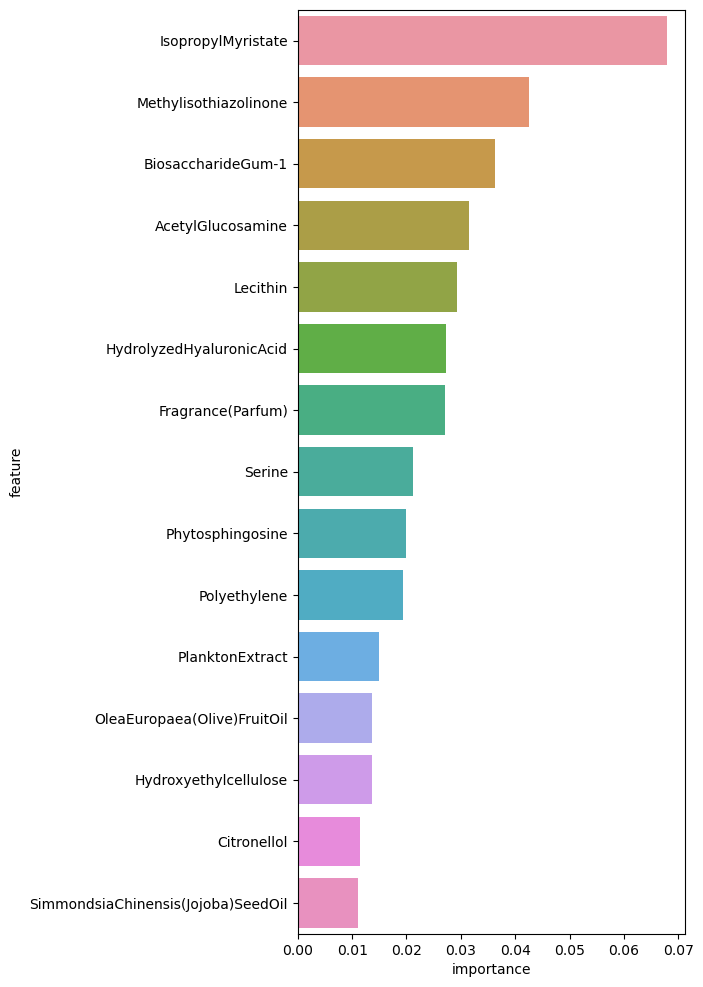

In [32]:
features_df = pd.DataFrame()
features_df["feature"] = X_train.columns
features_df["importance"] = boost.feature_importances_
features_df = features_df.sort_values("importance", ascending=False)
plt.figure(figsize=(5,12))
sns.barplot(x = "importance", y = "feature", data=features_df.iloc[:15])
plt.show()

## Predictions

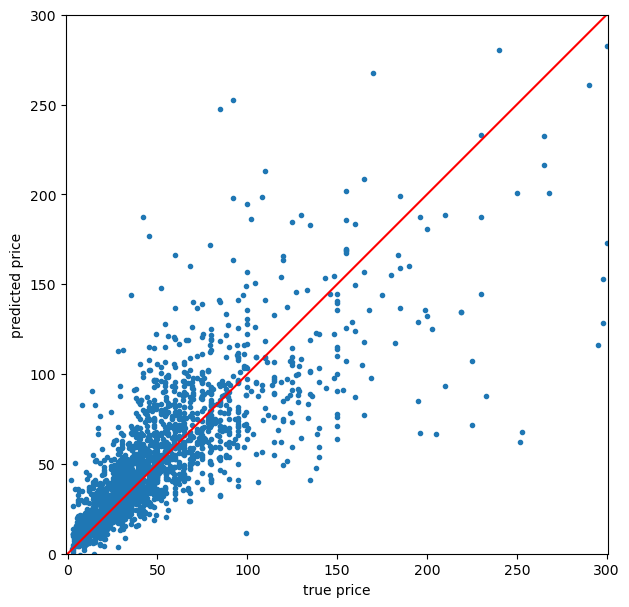

In [33]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, pred_test_boost, marker='.')
plt.plot([0,300],[0,300],color='r')
plt.axis('equal')
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel('true price')
plt.ylabel('predicted price')
plt.show()

In [34]:
df_prices = df_ing.loc[y_test.index.to_list()]
df_prices = df_prices[["product_names", "product_category", "brand", "ingredient"]]
df_prices["real_price"] = y_test
df_prices["predicted_price"] = model1_test_pred
df_prices["difference"] = (df_prices["real_price"] - df_prices["predicted_price"]).round(2)
df_prices

,product_names,product_category,brand,ingredient,real_price,predicted_price,difference
625,Rose Eye Makeup Remover,Cleansers,Chantecaille,"Rosa Damascena Flower Water, Disodium Lauroam...",39.00,38.887558,0.11
2796,Regenerist Micro-Sculpting Cream Fragrance Free,Nighttime Moisturizer,Olay,"Water, Glycerin, Isohexadecane, Niacinamide...",29.99,31.279379,-1.29
101,Clear Difference Advanced Blemish Serum,Acne & Blemish Treatment,Estee Lauder,Active Ingredients: Salicylic Acid 0.5% Inacti...,54.00,106.662117,-52.66
4767,Advanced Marine Biology Tonic,Toner & Face Mist,La Prairie,"SD Alcohol 40-B (Alcohol Denat.), Ethyl Perfl...",100.00,194.546127,-94.55
2018,Clear Improvement Active Charcoal Mask to Clea...,Face Mask,Origins,"Water, Myrtus Communis (Myrtle) Leaf Water, ...",27.00,22.022812,4.98
...,...,...,...,...,...,...,...
5208,HydroPeptide Solar Defense Tinted SPF 30 (1.7 ...,Serum,HydroPeptide,"Titanium Dioxide 2.5%, Zinc Oxide 6%, <p>Water...",49.00,96.424492,-47.42
6826,Peter Thomas Roth 24K Gold Pure Luxury Lift Fi...,Face Mask,Peter Thomas Roth,"Glycerin, Water, Sodium Hyaluronate, Caffeine,...",85.00,52.120281,32.88
292,Apricot & Manuka Honey Cleansing Stick,Cleansers,St. Ives,"Sodium Cocoyl Isethionate, Glycerin, Water, ...",7.99,21.059162,-13.07
5843,Bioderma Hydrabio Cream (1.67 fl. oz.),Serum,Bioderma,"Water, glycerin, isododecane, cyclopentasiloxa...",29.99,52.510612,-22.52


In [35]:
overpriced = df_prices.loc[df_prices["difference"] > 20]
overpriced.brand.value_counts().head(10)

iS Clinical      6
Clarins          5
SK-II            5
PCA SKIN         4
Neocutis         4
Lancome          4
Natura Bissé     4
Replenix         4
Dermalogica      4
Dr. Hauschka     4
Name: brand, dtype: int64

In [36]:
underpriced = df_prices.loc[df_prices["difference"] < 0]
underpriced.brand.value_counts().head(10)

Neutrogena                 26
Clinique                   21
L'Oreal Paris              20
Olay                       17
Kiss My Face               16
Estee Lauder               16
Coppertone                 16
Shiseido                   16
Paula's Choice Skincare    15
Kate Somerville            14
Name: brand, dtype: int64

# Dupe Machine

In [37]:
# remove non-essential columns
features = df_ing.copy()
features = features.drop(columns = ["product_names", "size", "size_num", "size_unit", "brand", "active_ingredient", 
                        "inactive_ingredient", "ingredient"])
features = pd.get_dummies(features)

# fit KNN model
model = NearestNeighbors(n_neighbors=2, algorithm='ball_tree')
model.fit(features)
dist, idlist = model.kneighbors(features)

In [38]:
# define function
def SuperDuper(product_name):
    product_list = []
    product_id = df_ing[df_ing["product_names"] == product_name].index
    product_id = product_id[0]
    product_price = df_ing["price"].iloc[product_id] 
    for newid in idlist[product_id]:
        name = df_ing.loc[newid].product_names
        brand = df_ing.loc[newid].brand
        price = df_ing.loc[newid].price
        if name == product_name:
            pass
        elif price < product_price:
            product_list.append(f"{name} from {brand}, ${price: .2f}")
        
    return product_list   

In [39]:
SuperDuper("Absolue Premium Bx Advanced Replenishing Cream Cleanser")

['Filorga Skin-Unify Radiance Perfecting Face Serum 15ml  from Filorga , $ 54.00']

In [40]:
features

,2-Hexanediol,AcetylGlucosamine,AcetylHexapeptide-8,Acrylamide/SodiumAcryloyldimethyltaurateCopolymer,Acrylates/C10-30AlkylAcrylateCrosspolymer,AcrylatesCopolymer,Adenosine,Alanine,Alcohol,AlcoholDenat,...,product_category_Lip Balm,product_category_Lip Scrub,product_category_Nighttime Moisturizer,product_category_Oil Control Products,product_category_Retinol,product_category_Serum,product_category_Skin Lightener,product_category_Sunscreen,product_category_Toner & Face Mist,product_category_Vitamin C
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7444,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7446,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
products_data = df[["brand", "product_names"]]

In [47]:
products_data.to_csv(r"data/products_data.csv")

In [49]:
products_data.to_pickle("./products_data.pkl") 

In [48]:
features.to_csv(r"data/features.csv")